In [1]:
from pathlib import Path
root_path = Path().cwd().parent.absolute()
import sys 
sys.path.append(str(root_path))

In [2]:
import torch as torch
from torch.distributions import MultivariateNormal
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import numpy as np
import matplotlib.pyplot as plt

import parametric_pushforward.data_sets as toy_data
from parametric_pushforward.parametric_mlp import order_state_to_tensor, MLP,torch_wrapper,ParameterizedMLP,ParameterizedWrapper
from parametric_pushforward.setup_density_path import get_activation

from flow_matching.train_fm import ACTIVATION_FNS


import parametric_pushforward.parametric_ode_solvers
from torchdyn.core import NeuralODE



from geomloss import SamplesLoss

import yaml
import os


Successfully patched Parametric_Euler and Parametric_Midpoint


In [3]:
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)

In [4]:
exp_dir = str(root_path)+'/models/8gaussiansv3_4gaussians[2,256,4,softplus]'
yaml_path = os.path.join(exp_dir,'config.yaml')
with open(yaml_path) as file:
    config = yaml.load(file,Loader = yaml.FullLoader)

In [5]:
reference_data_set = config['data']['reference']
target_data_set = config['data']['target']
input_dim = config['model']['input_dim']
hidden_dim = config['model']['hidden_dim']
num_layers = config['model']['num_layers']
activation = ACTIVATION_FNS[config['model']['activation_fn']]
time_varying = config['model']['time_varying']

arch = [input_dim,hidden_dim,num_layers,activation]

model = MLP(arch=arch,time_varying=time_varying)

state_path = os.path.join(exp_dir,'final.pth') #  checkpoint_999.pth #final
state_tensor = torch.load(state_path,map_location=device)['model_state_dict']

model.load_state_dict(state_dict=state_tensor)

model = torch_wrapper(model)


In [6]:
activation = get_activation(config['model']['activation_fn'])
arch = [input_dim,hidden_dim,num_layers,activation]

In [7]:
theta = order_state_to_tensor(state_tensor)
parametric_model = ParameterizedWrapper(ParameterizedMLP(arch,time_varying=time_varying),theta=theta)

In [25]:
t_node = torch.linspace(0,1,20).to(device)
node = NeuralODE(model,solver = 'midpoint').to(device)
parametric_node = NeuralODE(parametric_model,solver = 'midpoint').to(device)


In [26]:
bs = 5000

z = torch.from_numpy(toy_data.inf_train_gen(data=reference_data_set,batch_size=bs,dim = config['model']['input_dim'])).to(device)
trajecotry = node.trajectory(z,t_span=t_node)
par_trajectory = parametric_node.trajectory(z,t_span=t_node)

node_samples = trajecotry[-1].detach().cpu()
par_node_samples = par_trajectory[-1].detach().cpu()

true_samples = torch.from_numpy(toy_data.inf_train_gen(data=target_data_set,batch_size=bs,dim = config['model']['input_dim']))

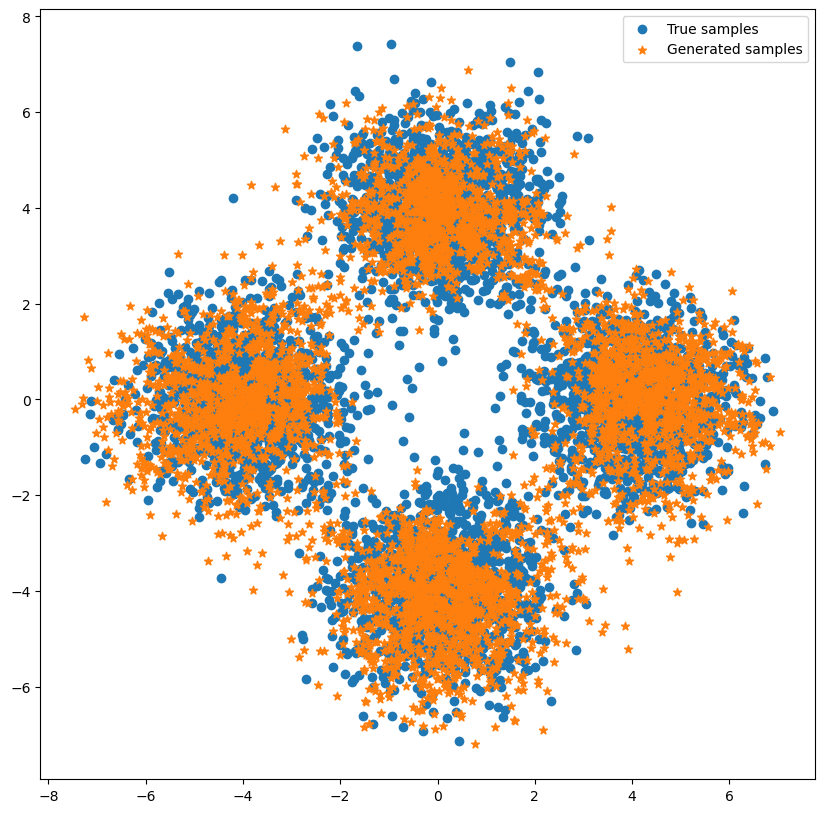

In [27]:
# Compare pushforward samples
fig = plt.figure(figsize=(10,10))
plt.scatter(true_samples[:,0],true_samples[:,1],label = 'True samples')
plt.scatter(par_node_samples[:,0],par_node_samples[:,1],label='Generated samples',marker = '*')

plt.legend()

In [28]:
true_samples.shape,node_samples.shape

(torch.Size([5000, 2]), torch.Size([5000, 2]))

In [16]:
loss = SamplesLoss()
L = loss(node_samples,true_samples)
L.item()



0.07560738921165466

In [17]:
# Compare pullback samples



t_node_inv = torch.linspace(1,0,20).to(device)

trajectory = node.trajectory(true_samples.to(device),t_span=t_node_inv)


node_samples = trajectory[-1].detach().cpu()

samples_prior = torch.from_numpy(toy_data.inf_train_gen(data=reference_data_set,batch_size=bs,dim = config['model']['input_dim'])).to(device)

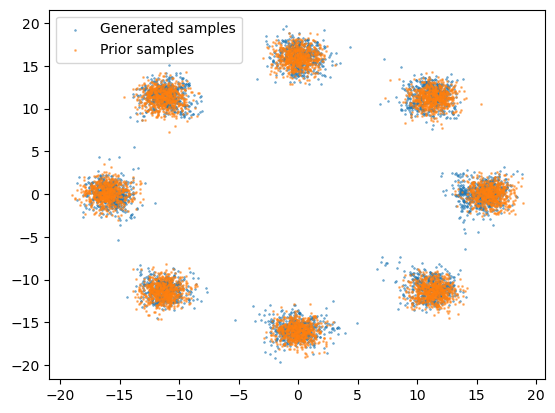

In [18]:
plt.scatter(node_samples[:,0],node_samples[:,1],label='Generated samples',marker = '*',alpha=0.5,s=1)
plt.scatter(samples_prior[:,0].cpu().detach(),samples_prior[:,1].cpu().detach(),label='Prior samples',alpha=0.5,s=1)
plt.legend()
plt.show()